In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
import numpy as np
# import torch
# import torch.distributions.categorical
import scipy
import scipy.stats
import math


In [2]:
def adjust_qr(rx, rp, rz):
    
    rz_new, rp_new = np.unique(rz, return_counts=True)
    rp_new = rp_new * rp[0]
    rx_new= np.arange(0, len(rz_new), 1)
    
    return rx_new, rp_new, rz_new

In [3]:
def VaR(z, p, lim):
    var = 0
    cum_p = 0
    for j, atom in enumerate(p):
        cum_p += atom
        if cum_p>= lim:
            var = z[j]
            break
    return var

def CVaR (z, p, var, lim):
    cvar = var
    expected_c = 0 
    for i, j in enumerate(p):
        if p[i] > 0:
            expected_c += j * max(0, z[i]-var)
    cvar+= 1/(1- alpha) * expected_c
    return cvar

def variance(z, p):
    average = np.average(z, weights=p)
    variance = np.average((z-average)**2, weights=p)
    return variance

def weighted_mean(z,p):
    return np.average(z, weights=p)

def prob_threshold(z, p, thresh):
    cum_p = 0
    for j, atom in enumerate(p):        
        if z[j]>= thresh:
            cum_p += atom
            
    return cum_p

In [85]:
# Graph Formating
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True
})
graphsize = 35
file_path = 'tests/experiments/'
experiment_name='gridmap10'
alg_type = 'vi' # Used only for the DTMC graph
rep_type = 'c51'
save_graphs = False

In [86]:
alpha=0.7
thresh=30
xmax = 80
ymax=0.3

## Graphs

##### DTMC

Reading file: tests/experiments/gridmap10/gridmap10_distr_dtmc_cvar_c51.csv
515
1.0000000000000009 True
max p: 0.19260482092200887


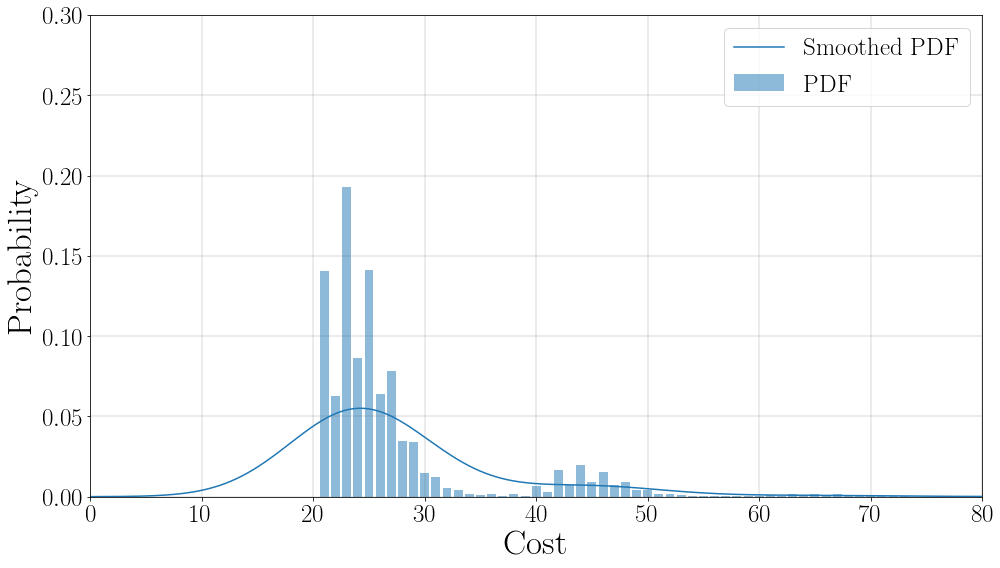

Saving to:tests/experiments/gridmap10/gridmap10_distr_dtmc_cvar_c51.png


In [87]:
print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+'.csv')
dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+'.csv')
#dist.head(10)
rx = dist['r'].to_numpy()
rp = dist['p'].to_numpy()
n = np.max(np.where(rp > 1e-20))
rx = rx[0:n+1]
rp = rp[0:n+1]
# z = z[0:n+1]
print(n)
print(np.sum(rp), np.allclose(np.sum(rp), 1))
print("max p:", np.max(rp))
distr = scipy.stats.rv_discrete(values=(rx, rp))
# h = plt.bar(rx, rp, alpha=0.5)
fig = plt.figure(figsize=(14,8))
h = plt.bar(rx, distr.pmf(rx), alpha=0.5, label='PDF')
kernel = scipy.stats.gaussian_kde(rx, weights=rp)
range = np.arange(0, n, 0.1)
plt.plot(range, kernel(range), label='Smoothed PDF')
plt.xlim([0,xmax])
plt.ylim([0,ymax])

plt.legend(loc='upper right', fontsize=graphsize-10)
plt.tick_params(axis='both', which='major', labelsize=graphsize-10)
plt.ticklabel_format(axis='both')
plt.xlabel('Cost', fontsize=graphsize)
plt.ylabel('Probability', fontsize=graphsize)
plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
plt.tight_layout()
plt.show()
# plt.fill_between(range, kernel(range))

if save_graphs:
    print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+".png")
    fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+".png", transparent=True, dpi=400)

In [88]:
print(f"Mean : {weighted_mean(rx, rp)}")
print(f"Variance : {variance(rx, rp)}")
var_dtmc = VaR(rx, rp, alpha) 
print(f"Value at Risk for {alpha} : {var_dtmc}")
print(f"Conditional VaR for {alpha} : {CVaR(rx, rp, var_dtmc, alpha),}")
print(f"Prob cost > {thresh} : {prob_threshold(rx, rp, thresh)}")
print(weighted_mean(rx, rp),",",variance(rx, rp),",",var_dtmc,",", CVaR(rx, rp, var_dtmc, alpha),",",prob_threshold(rx, rp, thresh))

Mean : 27.324438648183378
Variance : 74.21081824270449
Value at Risk for 0.7 : 27
Conditional VaR for 0.7 : (36.52163402620734,)
Prob cost > 30 : 0.16591645659367754
27.324438648183378 , 74.21081824270449 , 27 , 36.52163402620734 , 0.16591645659367754


##### Expected Value Iteration

Reading file: tests/experiments/gridmap10/gridmap10_distr_exp_c51.csv
101
1.0000000000000004 True
max p: 0.24603835510825206


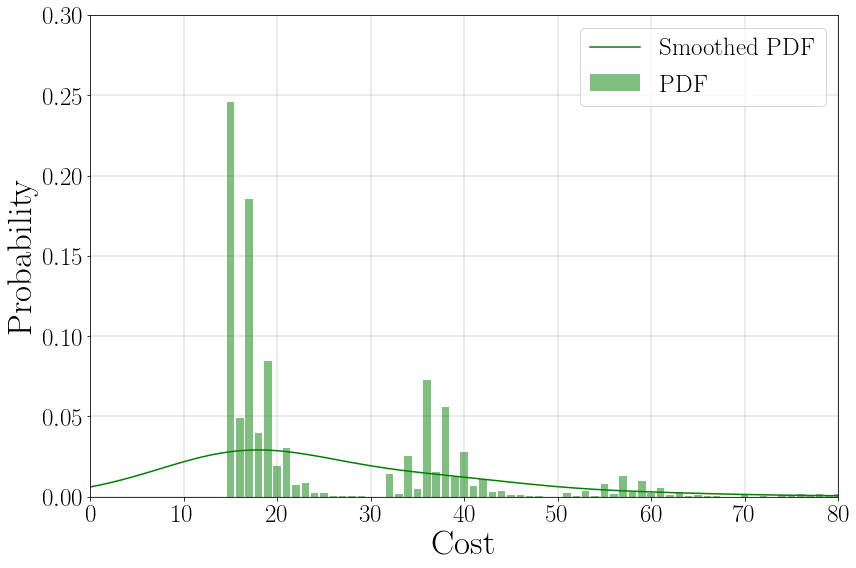

In [73]:
print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+'.csv')
dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+'.csv')
#dist.head(10)
rx_e = dist['r'].to_numpy()
rp_e = dist['p'].to_numpy()
z_e = dist['z'].to_numpy()
n = np.max(np.where(rp_e > 1e-8))
rx_e = rx_e[0:n+1]
rp_e = rp_e[0:n+1]
z_e = z_e[0:n+1]

print(len(dist.index))
print(np.sum(rp_e), np.allclose(np.sum(rp_e), 1))
print("max p:", np.max(rp_e))
distr_e = scipy.stats.rv_discrete(values=(z_e, rp_e))
# h = plt.bar(rx_e, rp_e, alpha=0.5)
fig = plt.figure(figsize=(12,8))
h = plt.bar(z_e, rp_e, alpha=0.5, color='g', label='PDF')
kernel = scipy.stats.gaussian_kde(z_e, weights=rp_e)
range = np.arange(0, z_e[-1]+z_e[1], z_e[1]) 
plt.plot(range, kernel(z_e), color='g', label='Smoothed PDF')
plt.xlim([0,xmax])
plt.ylim([0,ymax])

plt.legend(loc='upper right', fontsize=graphsize-10)
plt.tick_params(axis='both', which='major', labelsize=graphsize-10)
plt.ticklabel_format(axis='both')
plt.xlabel('Cost', fontsize=graphsize)
plt.ylabel('Probability', fontsize=graphsize)
plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
plt.tight_layout()
plt.show()
# plt.fill_between(range, kernel(range))

if save_graphs:
    fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+".png", transparent=True, dpi=400)

In [74]:
print(f"Mean : {weighted_mean(z_e, rp_e)}")
print(f"Variance : {variance(z_e, rp_e)}")
var_exp = VaR(z_e, rp_e, alpha) 
print(f"Value at Risk : {var_exp}")
print(f"Conditional VaR: {CVaR(z_e, rp_e, var_exp, alpha)}")
print(f"Prob cost > {thresh} : {prob_threshold(z_e, rp_e, thresh)}")
print(f"{weighted_mean(z_e, rp_e)},{variance(z_e, rp_e)},{var_exp},{CVaR(z_e, rp_e, var_exp, alpha)},{prob_threshold(z_e, rp_e, thresh)}")

Mean : 25.21822761297509
Variance : 186.95529870116113
Value at Risk : 34.0
Conditional VaR: 43.21192699169572
Prob cost > 30 : 0.32356147123902657
25.21822761297509,186.95529870116113,34.0,43.21192699169572,0.32356147123902657


##### CVaR

Reading file: tests/experiments/gridmap10/gridmap10_distr_cvar_c51.csv
100
1.0000000000000004 True
max p: 0.19260482092200887


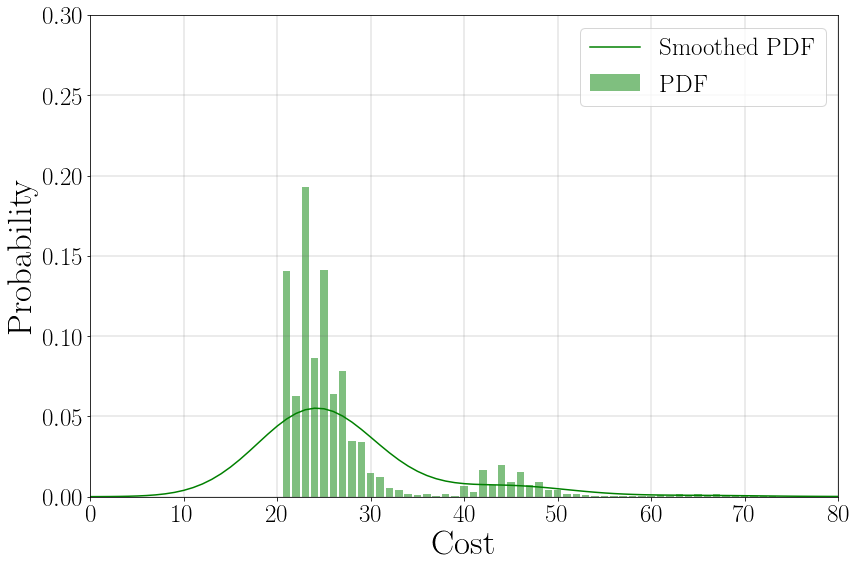

Saving to:tests/experiments/gridmap10/gridmap10_distr_cvar_c51.png


In [75]:
print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+'.csv')
dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+'.csv')
#dist.head(10)
rx_c = dist['r'].to_numpy()
rp_c = dist['p'].to_numpy()
z_c = dist['z'].to_numpy()
n = np.max(np.where(rp_c > 1e-6))
rx_c = rx_c[0:n+1]
rp_c = rp_c[0:n+1]
z_c = z_c[0:n+1]
print(n)
print(np.sum(rp_c), np.allclose(np.sum(rp_c), 1))
print("max p:", np.max(rp_c))
distr_c = scipy.stats.rv_discrete(values=(z_c, rp_c))
# h = plt.bar(rx_c, rp_c, alpha=0.5)
fig=plt.figure(figsize=(12,8))
h = plt.bar(z_c, rp_c, alpha=0.5, color='g', label='PDF')
kernel = scipy.stats.gaussian_kde(z_c, weights=rp_c)
range = np.arange(0, z_c[-1]+z_c[1], z_c[1]) 
plt.plot(range, kernel(range), color='g', label='Smoothed PDF')
plt.xlim([0,xmax])
plt.ylim([0,ymax])

plt.legend(loc='upper right', fontsize=graphsize-10)
plt.tick_params(axis='both', which='major', labelsize=graphsize-10)
plt.ticklabel_format(axis='both')
plt.xlabel('Cost', fontsize=graphsize)
plt.ylabel('Probability', fontsize=graphsize)
plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
plt.tight_layout()
plt.show()
# plt.fill_between(range, kernel(range))

if save_graphs:
    print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+".png")
    fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+".png", transparent=True, dpi=400)

In [76]:
print(f"Mean : {weighted_mean(z_c, rp_c)}")
print(f"Variance : {variance(z_c, rp_c)}")
var_exp = VaR(z_c, rp_c, alpha) 
print(f"Value at Risk : {var_exp}")
print(f"Conditional VaR: {CVaR(z_c, rp_c, var_exp, alpha)}")
print(f"Prob cost > {thresh} : {prob_threshold(z_c, rp_c, thresh)}")
print(f"{weighted_mean(z_c, rp_c)},{variance(z_c, rp_c)},{var_exp},{CVaR(z_c, rp_c, var_exp, alpha)},{prob_threshold(z_c, rp_c, thresh)}")

Mean : 27.32264038620908
Variance : 73.86729769078296
Value at Risk : 27.0
Conditional VaR: 36.5156398196263
Prob cost > 30 : 0.1659164565936778
27.32264038620908,73.86729769078296,27.0,36.5156398196263,0.1659164565936778


### Debugging

In [61]:
z_c

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])

In [125]:
rx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171])

In [124]:
rp_c

array([1.88055423e-16, 7.60895559e-15, 1.50388177e-13, 2.61631202e-09,
       4.82070682e-08, 4.29124819e-07, 1.14260387e-05, 1.35392735e-04,
       8.62333127e-04, 3.57049409e-03, 1.06640733e-02, 2.45131179e-02,
       4.53995809e-02, 7.02033476e-02, 9.33399063e-02, 1.09371364e-01,
       1.15297037e-01, 1.11208544e-01, 9.94855098e-02, 8.34460974e-02,
       6.62087336e-02, 5.00652333e-02, 3.63257103e-02, 2.54598770e-02,
       1.73604236e-02, 1.16086038e-02, 7.68069539e-03, 5.07799410e-03,
       3.38936227e-03, 2.30669090e-03, 1.61434067e-03, 1.16860713e-03,
       8.76800187e-04, 6.80239440e-04, 5.42139784e-04, 4.39709710e-04,
       3.59227749e-04, 2.92920757e-04, 2.36812923e-04, 1.89117036e-04,
       1.49041826e-04, 1.16020326e-04, 8.93473656e-05, 6.81337464e-05,
       5.14266000e-05, 3.83518624e-05, 2.81937469e-05, 2.03966969e-05,
       1.45213699e-05, 1.01959041e-05, 2.24271869e-05])

In [126]:
rp

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.38412872e-02, 2.49143170e-02, 2.61600328e-02, 4.58423432e-02,
       5.89721882e-02, 5.55639097e-02, 6.84921979e-02, 7.49130658e-02,
       6.58677524e-02, 6.94185090e-02, 6.89302350e-02, 5.77841948e-02,
       5.56075158e-02, 5.17785836e-02, 4.19238502e-02, 3.79993686e-02,
       3.37980312e-02, 2.66537226e-02, 2.31513815e-02, 1.98974780e-02,
       1.53711130e-02, 1.29322555e-02, 1.08227751e-02, 8.22342432e-03,
       6.74923223e-03, 5.52963027e-03, 4.14489968e-03, 3.33504734e-03,
       2.68544700e-03, 1.99029537e-03, 1.57563973e-03, 1.25058743e-03,
      

In [102]:
rp_c

array([1.88055423e-16, 7.60895559e-15, 1.50388177e-13, 2.61631202e-09,
       4.82070682e-08, 4.29124819e-07, 1.14260387e-05, 1.35392735e-04,
       8.62333127e-04, 3.57049409e-03, 1.06640733e-02, 2.45131179e-02,
       4.53995809e-02, 7.02033476e-02, 9.33399063e-02, 1.09371364e-01,
       1.15297037e-01, 1.11208544e-01, 9.94855098e-02, 8.34460974e-02,
       6.62087336e-02, 5.00652333e-02, 3.63257103e-02, 2.54598770e-02,
       1.73604236e-02, 1.16086038e-02, 7.68069539e-03, 5.07799410e-03,
       3.38936227e-03, 2.30669090e-03, 1.61434067e-03, 1.16860713e-03,
       8.76800187e-04, 6.80239440e-04, 5.42139784e-04, 4.39709710e-04,
       3.59227749e-04, 2.92920757e-04, 2.36812923e-04, 1.89117036e-04,
       1.49041826e-04, 1.16020326e-04, 8.93473656e-05, 6.81337464e-05,
       5.14266000e-05, 3.83518624e-05, 2.81937469e-05, 2.03966969e-05,
       1.45213699e-05, 1.01959041e-05, 2.24271869e-05])

## Statistics

In [142]:

sample_dtmc = np.random.choice(rx, 5000, p=rp)
sample_cvar = np.random.choice(z_c, 5000, p=rp_c)

stats.ks_2samp(sample_cvar, sample_dtmc)

KstestResult(statistic=0.0898, pvalue=5.865928454953228e-18)

In [146]:
stats.epps_singleton_2samp(sample_dtmc, sample_cvar)

Epps_Singleton_2sampResult(statistic=268.4622306016531, pvalue=6.842959268883822e-57)

<AxesSubplot:ylabel='Probability'>

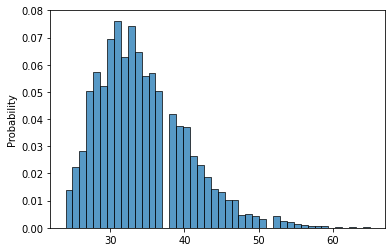

In [143]:
import seaborn as sns
sns.histplot(sample_dtmc, stat='probability')

<AxesSubplot:ylabel='Probability'>

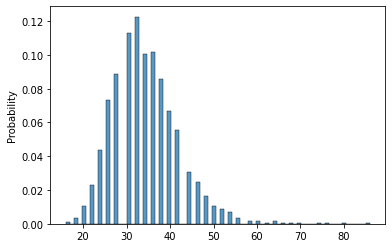

In [144]:
sns.histplot(sample_cvar, stat='probability')

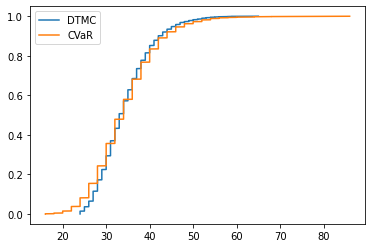

In [145]:
x1 = np.sort(sample_dtmc)
x2 = np.sort(sample_cvar)
y = 1. * np.arange(len(sample_dtmc)) / (len(sample_dtmc) - 1)

#plot CDF

plt.plot(x1, y, label='DTMC')
plt.plot(x2, y, label='CVaR')
plt.legend()
plt.show()

In [98]:
distr

In [5]:
arr = np.array([0.000, 0.500, 0.250, 0.125, 0.062, 0.031, 0.016, 0.008, 0.004, 0.002, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])

In [6]:
z = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0])

In [17]:
arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17022753571453167, 0.31891492215823797, 0.1567626480513812, 0.05118216018499157, 0.013643989313244502, 0.0032351774801199894, 7.130268323753448E-4, 1.4984610011878512E-4, 3.0513044244107402E-5, 2.4603800653719168E-5, 0.001396588456150835, 0.042334917847358385, 0.09208631431008223, 0.05761650606557643, 0.04320529099424163, 0.02221523535712152, 0.01640335150815666, 0.00696340710405944, 0.002162493290883658, 5.632152543138403E-4, 1.318578710495575E-4, 2.884003657870519E-5, 6.031651041796671E-6, 1.5275734870121406E-6])

In [18]:
len(arr)

31

(0.0, 0.6)

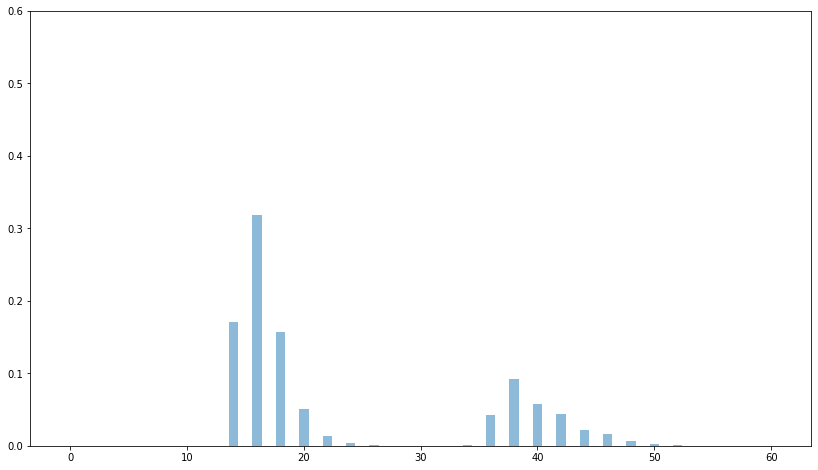

In [19]:
plt.figure(figsize=(14,8))
plt.bar(z,arr[:31], alpha=0.5)
plt.ylim([0, 0.6])

In [9]:
arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17022753571453167, 0.31891492215823797, 0.1567626480513812, 0.05118216018499157, 0.013643989313244502, 0.0032351774801199894, 7.130268323753448E-4, 1.4984610011878512E-4, 3.0513044244107402E-5, 2.4603800653719168E-5, 0.001396588456150835, 0.042334917847358385, 0.09208631431008223, 0.05761650606557643, 0.04320529099424163, 0.02221523535712152, 0.01640335150815666, 0.00696340710405944, 0.002162493290883658, 5.632152543138403E-4, 1.318578710495575E-4, 2.884003657870519E-5, 6.031651041796671E-6, 1.5275734870121406E-6])

In [10]:
len(arr)

31

(0.0, 60.0)

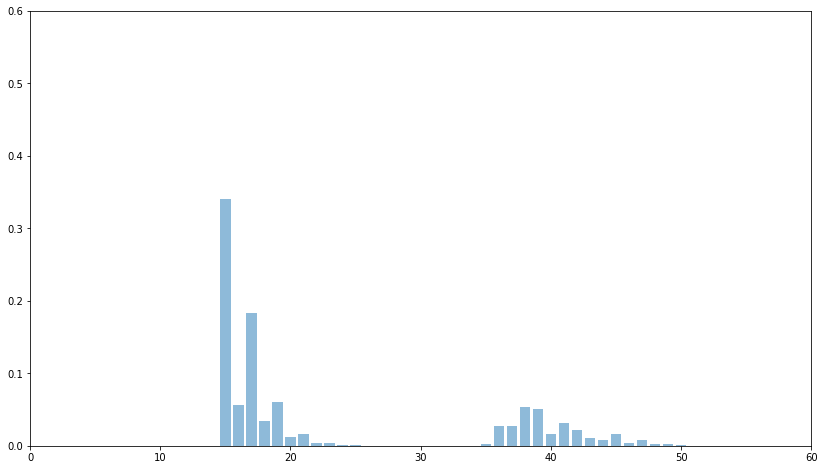

In [8]:
plt.figure(figsize=(14,8))
plt.bar(z,arr, alpha=0.5)
plt.ylim([0, 0.6])
plt.xlim([0,60])

In [22]:
arr2 = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.341, 0.207, 0.228, 0.103, 0.068, 0.028, 0.014, 0.006, 0.003, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])

In [23]:
arr2.shape

(201,)

(0.0, 130.0)

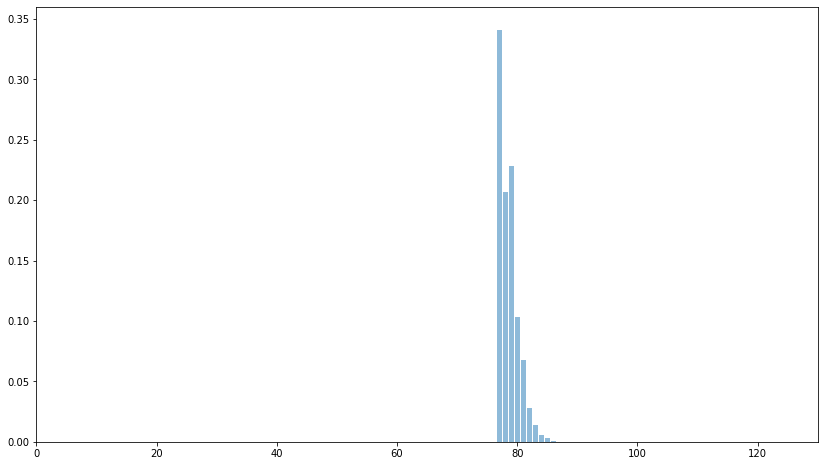

In [25]:
plt.figure(figsize=(14,8))
plt.bar(np.arange(201),arr2, alpha=0.5)
plt.ylim([0, 0.36])
plt.xlim([0, 130])

In [12]:
arr_qr = np.array([37.000, 37.000, 37.000, 37.000, 37.000, 37.000, 39.000, 39.000, 39.000, 39.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 52.000, 52.000, 52.000, 52.000, 52.000, 52.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 54.000, 54.000, 55.000, 55.000, 55.000, 55.000, 56.000, 57.000, 57.000, 59.000, 59.000, 59.000, 60.000, 61.000, 61.000, 61.000, 61.000, 61.000, 61.000, 61.000, 62.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 68.000, 69.000, 69.000, 69.000, 69.000, 70.000, 70.000, 71.000, 71.000, 71.000, 71.000, 73.000, 73.000, 79.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 90.000, 90.000, 90.000, 91.000, 91.000, 91.000, 91.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 93.000, 93.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 95.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 97.000, 97.000, 98.000, 98.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 102.000, 102.000, 102.000, 102.000, 102.000, 102.000, 102.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 106.000, 106.000, 106.000, 106.000, 106.000, 106.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 108.000, 108.000, 108.000, 109.000, 109.000, 109.000, 109.000, 109.000, 110.000, 111.000, 111.000, 111.000, 111.000, 111.000])

In [13]:
atoms = 1000
delta_p = 1.0/atoms
arr_conv = np.zeros(201)

for j in np.arange(atoms):
    val = arr_qr[j]
    low = math.floor(val)
    upp = math.ceil(val)
    if low - upp != 0:
        arr_conv[low] += (val - low) * delta_p
        arr_conv[upp] += (upp - val) * delta_p
    else:
        arr_conv[low] += delta_p
    
arr_conv

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.006, 0.   , 0.004, 0.   , 0.082, 0.014, 0.14 , 0.023,
       0.131, 0.021, 0.084, 0.017, 0.043, 0.01 , 0.016, 0.006, 0.009,
       0.002, 0.004, 0.001, 0.002, 0.   , 0.003, 0.001, 0.007, 0.001,
       0.012, 0.   , 0.013, 0.   , 0.008, 0.001, 0.004, 0.002, 0.004,
       0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   ,
       0.019, 0.024, 0.027, 0.028, 0.028, 0.014, 0.023, 0.008, 0.013,
       0.003, 0.004, 0.013, 0.002, 0.01 , 0.001, 0.012, 0.002, 0.002,
       0.014, 0.008, 0.009, 0.007, 0.008, 0.01 , 0.008, 0.006, 0.009,
       0.003, 0.005, 0.001, 0.005, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,